In [1]:
#  MNIST and Convolutional Neural Network
import os
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import time

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


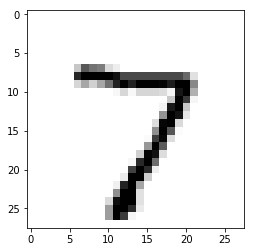

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


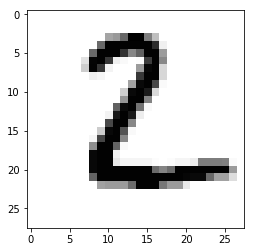

In [4]:
num=2
for r in range(num):
    print(mnist.test.labels[r])
    plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [5]:
# hyper parameters
learning_rate = 0.01
training_epochs = 8
batch_size = 8192

In [6]:
# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.float32, [None, 10])

In [7]:
# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [8]:
# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
L3_flat = tf.reshape(L3, [-1, 4 * 4 * 128])

In [10]:
# Final FC 4x4x128 inputs -> 10 outputs
W4 = tf.get_variable("W4", shape=[4 * 4 * 128, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L3_flat, W4) + b

In [11]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [12]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes 10 minutes.')
s=time.time()
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {X: batch_xs, Y: batch_ys}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

e=time.time()
lap_time=e-s
print('Learning Finished!')
print( '{:.0f}'.format(lap_time), '초 결렸습니다!')

Learning started. It takes 10 minutes.
Epoch: 0001 cost = 3.175169428
Epoch: 0002 cost = 2.683563193
Epoch: 0003 cost = 2.633621772
Epoch: 0004 cost = 2.328841925
Epoch: 0005 cost = 1.890086571
Epoch: 0006 cost = 0.970623036
Epoch: 0007 cost = 0.672948251
Epoch: 0008 cost = 0.471372510
Learning Finished!
628 초 결렸습니다!


In [13]:
# Test model and check accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Optimization Finished! \nTesting Accuracy:', sess.run(accuracy, feed_dict={
      X: mnist.test.images, Y: mnist.test.labels}))

Optimization Finished! 
Testing Accuracy: 0.8842


Label:  [7]
Prediction:  [7]


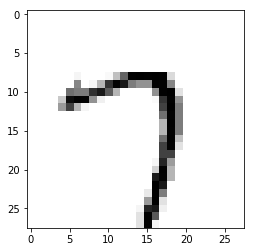

In [14]:
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
print("Prediction: ", sess.run(
    tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1]}))
plt.imshow(mnist.test.images[r:r + 1].reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()